<a href="https://colab.research.google.com/github/HaaLeo/vague-requirements-scripts/blob/master/colab-notebooks/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify requirements as vague or not using [ktrain](https://github.com/amaiya/ktrain) and tensorflow


## Install dependencies
*ktrain* requires TensorFlow 2.1. See [amaiya/ktrain#151](https://github.com/amaiya/ktrain/issues/151).
Further we install a forked version of eli5lib to gain insights in the model's decision process and some self built helper functions to preprocess MTurk result files.

In [2]:
!pip3 install -q tensorflow_gpu==2.1.0 ktrain==0.17.5
!pip3 install -q -U git+https://github.com/HaaLeo/vague-requirements-scripts
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

     |████████████████████████████████| 25.2MB 127kB/s 


Check versions and enable logging

In [3]:
import tensorflow as tf
import ktrain
assert tf.__version__ == '2.1.0'
assert ktrain.__version__ == '0.17.5'

import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(threadName)-20.20s] [%(levelname)-5.5s]  %(message)s',
    stream=sys.stdout,
    level=logging.DEBUG)

## Set Parameters
Set the parameters for this run.
Ktrain ignores `max_features` and `ngram_range` in v0.17.5, see [amaiya/ktrain/issues#190](https://github.com/amaiya/ktrain/issues/190)

In [6]:
DATA_FILE_NAMES = [f'corpus-batch-{i}-mturk.csv' for i in range(5)]

RANDOM_STATE = 1 # for seeding

LEARNING_RATE = 5e-5
EPOCHS = 4
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 512
BATCH_SIZE = 6
MAX_FEATURES = 35_000
NGRAM_RANGE = 1

CLASS_NAMES = ['not-vague', 'vague'] # 0=not-vague 1=vague

PREPROCESS_MODE = 'distilbert'

## Load Dataset

### Mount Google Drive
Mount the google drive to access the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load Dataset Into Arrays

In [7]:
from vaguerequirementslib import read_csv_files, build_confusion_matrix, calc_majority_label
import pandas as pd

def read_drive_data(files_list: list, separator: str) -> pd.DataFrame:
    """
    Calculate the majority label for the given source file list

    Args:
        files_list (list): The CSV files to calculate the majority label for
        separator (str): The CSV separator
        drop_ties (bool): If there is a tie in votes (e.g.: One votes for vague one for not vague) then drop this entry from the confusion matrix.

    Returns:
        pd.DataFrame: The dataframe containing the majority label.
    """
    df = read_csv_files(files_list, separator)
    confusion_matrix = build_confusion_matrix(df, drop_ties=True)
    return calc_majority_label(confusion_matrix)

# Read all data
df = read_drive_data(
    [f'/content/drive/My Drive/datasets/corpus/labeled/{file_name}' for file_name in DATA_FILE_NAMES],
    ','
  )
df.head()

2020-07-06 20:10:57,159 [MainThread          ] [DEBUG]  Read file="/content/drive/My Drive/datasets/corpus/labeled/corpus-batch-0-mturk.csv" with 200 rows.
2020-07-06 20:10:57,915 [MainThread          ] [DEBUG]  Read file="/content/drive/My Drive/datasets/corpus/labeled/corpus-batch-1-mturk.csv" with 198 rows.
2020-07-06 20:10:58,731 [MainThread          ] [DEBUG]  Read file="/content/drive/My Drive/datasets/corpus/labeled/corpus-batch-2-mturk.csv" with 194 rows.
2020-07-06 20:10:59,484 [MainThread          ] [DEBUG]  Read file="/content/drive/My Drive/datasets/corpus/labeled/corpus-batch-3-mturk.csv" with 198 rows.
2020-07-06 20:11:00,224 [MainThread          ] [DEBUG]  Read file="/content/drive/My Drive/datasets/corpus/labeled/corpus-batch-4-mturk.csv" with 196 rows.
2020-07-06 20:11:00,248 [MainThread          ] [INFO ]  Build confusion matrix.
2020-07-06 20:11:00,425 [MainThread          ] [INFO ]  Dropped 223 requirements due to ties.
2020-07-06 20:11:00,428 [MainThread          ]

,requirement,vague_count,not_vague_count,majority_label
0,A fallback per band feature set resulting from...,2,0,1
1,A set of survivability characteristics and obj...,2,0,1
2,Actuation of steering shall be possible regard...,0,2,0
3,Additional spurious emission requirements are ...,0,2,0
4,"Additionally, the ZigBee end device shall then...",0,2,0


### Split data set


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from typing import Tuple, List
from ktrain import text as txt

def upsample(data_frame: pd.DataFrame) -> pd.DataFrame:
    """
    Up sample the given dataframe to contain equally much samples of vague and not-vague requirements.

    Args:
        data_frame (pd.DataFrame): The data frame to upsample.

    Returns:
        pd.DataFrame: The upsampled data frame.
    """
    vague_df = data_frame[data_frame.majority_label == 1]
    not_vague_df = data_frame[data_frame.majority_label == 0]

    if int(vague_df.majority_label.value_counts()) > int(not_vague_df.majority_label.value_counts()):
        df_to_upsample = not_vague_df
        majority_df = vague_df
    else:
        df_to_upsample = vague_df
        majority_df = not_vague_df

    upsampled_df = resample(
        df_to_upsample, 
        replace=True,     # sample with replacement
        n_samples=majority_df.shape[0],    # to match majority class
        random_state=RANDOM_STATE) # reproducible results
    result = pd.concat([upsampled_df, majority_df])

    print(f'Upsampled dataset: vague count="{result.sum()["majority_label"]}", not vague count="{result.shape[0] - result.sum()["majority_label"]}"')

    return result


def split_dataset(data_frame: pd.DataFrame) -> Tuple[List[str], List[int], List[str], List[int], List[str], List[int]]:
    """
    Split the dataset into training, validation and test set.

    Args:
        data_frame (pd.DataFrame): The data frame to generate the data sets from.

    Returns:
        Tuple[List[str], List[int], List[str], List[int], List[str], List[int]]: x_train, y_train, x_val, y_val, x_test, y_test
    """
    train_df, val_test_df = train_test_split(data_frame, test_size=0.2, random_state=RANDOM_STATE, stratify=data_frame['majority_label'])
    val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE, stratify=val_test_df['majority_label'])

    print(f'Training dataset: vague count="{train_df.sum()["majority_label"]}", not vague count="{train_df.shape[0] - train_df.sum()["majority_label"]}"')
    print(f'Validation dataset: vague count="{val_df.sum()["majority_label"]}", not vague count="{val_df.shape[0] - val_df.sum()["majority_label"]}"')
    print(f'Test dataset: vague count="{test_df.sum()["majority_label"]}", not vague count="{test_df.shape[0] - test_df.sum()["majority_label"]}"')

    return train_df, val_df, test_df


def preprocess_data(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple:
    def _preprocess(my_df: pd.DataFrame) -> Tuple:
        dummy_df = pd.DataFrame.from_dict({'requirement': ['foo', 'bar'], 'majority_label': [0, 1]})
        return txt.texts_from_df(my_df, text_column='requirement', label_columns=['majority_label'], val_df=dummy_df,  max_features=MAX_FEATURES, maxlen=MAX_LEN,  ngram_range=NGRAM_RANGE, preprocess_mode=PREPROCESS_MODE, random_state=RANDOM_STATE)
    
    train_data, _, _ = _preprocess(train_df)
    val_data, _, _ = _preprocess(val_df)
    test_data, _, test_preproc = _preprocess(test_df)

    return train_data, val_data, test_data, test_preproc

# Split the data set
train_df, val_df, test_df = split_dataset(df)

# Upsample train_df
train_df = upsample(train_df)

# Preprocess for Transfer Learning
train_data, val_data, test_data, test_preproc = preprocess_data(train_df, val_df, test_df)


Training dataset: vague count="47", not vague count="169"
Validation dataset: vague count="6", not vague count="21"
Test dataset: vague count="6", not vague count="21"
Upsampled dataset: vague count="169", not vague count="169"
preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 40
	99percentile : 57
2020-07-06 20:11:19,740 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-06 20:11:20,529 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0
2020-07-06 20:11:20,533 [MainThread          ] [DEBUG]  Attempting to acquire lock 140433243752880 on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
2020-07-06 20:11:20,538 [MainThread          ] [INFO ]  Lock 140433243752880 acquired on /root/.cache/torch/transformer


2020-07-06 20:11:22,239 [MainThread          ] [DEBUG]  Attempting to release lock 140433243752880 on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
2020-07-06 20:11:22,240 [MainThread          ] [INFO ]  Lock 140433243752880 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 20
	95percentile : 35
	99percentile : 38
2020-07-06 20:11:22,727 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-06 20:11:23,499 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


preprocessing train...
language: en
train sequence lengths:
	mean : 25
	95percentile : 54
	99percentile : 64
2020-07-06 20:11:23,743 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-06 20:11:24,516 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


## STEP 1:  Create a Transformer Model and Train it

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [17]:
from datetime import datetime
from pytz import timezone

# Create the transformer
t = txt.Transformer(MODEL_NAME, maxlen=MAX_LEN, class_names=CLASS_NAMES)
t.preprocess_train_called = True # Simulate call to preprocess_train()

# Get the model and learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=BATCH_SIZE)

# For every triggered fitting run create a new directory where the results will be saved
now = datetime.now(timezone('Europe/Berlin'))
result_dir = f'/content/drive/My Drive/runs/{now.strftime("%Y-%m-%d/%H-%M-%S")}'

# Fit the model
learner.fit_onecycle(LEARNING_RATE, EPOCHS)
learner.plot('loss')

2020-07-06 20:49:35,588 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): s3.amazonaws.com:443
2020-07-06 20:49:36,355 [MainThread          ] [DEBUG]  https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/distilbert-base-uncased-config.json HTTP/1.1" 200 0
2020-07-06 20:49:36,364 [MainThread          ] [DEBUG]  Starting new HTTPS connection (1): cdn.huggingface.co:443
2020-07-06 20:49:36,688 [MainThread          ] [DEBUG]  https://cdn.huggingface.co:443 "HEAD /distilbert-base-uncased-tf_model.h5 HTTP/1.1" 200 0


begin training using onecycle policy with max lr of 5e-05...
Train for 57 steps, validate for 1 steps
Epoch 1/4
57/57 [==============================] - 49s 853ms/step - loss: 0.6704 - accuracy: 0.5917 - val_loss: 0.7080 - val_accuracy: 0.5556
Epoch 2/4
57/57 [==============================] - 39s 683ms/step - loss: 0.3764 - accuracy: 0.8550 - val_loss: 0.6258 - val_accuracy: 0.7407
Epoch 3/4
57/57 [==============================] - 39s 685ms/step - l

## STEP 2: Evaluate the model
Evaluate the model using the `test_data`.

              precision    recall  f1-score   support

   not-vague       0.78      0.86      0.82        21
       vague       0.25      0.17      0.20         6

    accuracy                           0.70        27
   macro avg       0.52      0.51      0.51        27
weighted avg       0.66      0.70      0.68        27

[[18  3]
 [ 5  1]]
2020-07-06 20:57:55,614 [MainThread          ] [DEBUG]  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-07-06 20:57:55,616 [MainThread          ] [DEBUG]  findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-07-06 20:57:55,617 [MainThread          ] [DEBUG]  findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2020-07-06 20:57:55,621 [MainThread          ] [DEBUG]  findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2020-07-06 20:57:55,623 [MainThread          ] [DEBUG] 

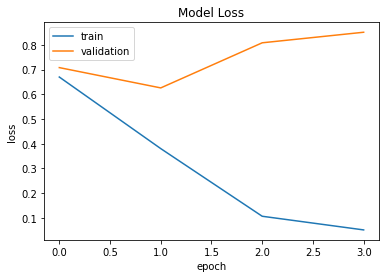

In [19]:
test_result = learner.validate(class_names=t.get_classes(), val_data=test_data)
print(test_result)
learner.plot('loss')

## STEP 3: Gather Results

Gather results, calulate metrics and write them to the drive.

In [11]:
import os
import json
from os import path

from vaguerequirementslib import TP, TN, FP, FN, calc_all_metrics

def build_result_data(test_result: List) -> dict:
    result_data = {
        'metrics':{
            'vague': {
                TP: int(test_result[1][1]),
                FP: int(test_result[0][1]),
                TN: int(test_result[0][0]),
                FN: int(test_result[1][0])
            },
            'not_vague': {
                TP: int(test_result[0][0]),
                FP: int(test_result[1][0]),
                TN: int(test_result[1][1]),
                FN: int(test_result[0][1])
            }
        },
        'misc': {   
            'data_files': DATA_FILE_NAMES,
            'random_state': RANDOM_STATE
        },
        'hyperparameter': {
            'learning_rate': LEARNING_RATE,
            'epochs': EPOCHS,
            'model_name': MODEL_NAME,
            'max_len': MAX_LEN,
            'batch_size': BATCH_SIZE,
            'max_features': MAX_FEATURES,
            'ngram_range': NGRAM_RANGE
        }
    }
    result_data['metrics']['not_vague'].update(calc_all_metrics(**result_data['metrics']['not_vague']))
    result_data['metrics']['vague'].update(calc_all_metrics(**result_data['metrics']['vague']))
    
    return result_data

result_data = build_result_data(test_result)
# Get the predictor
predictor = ktrain.get_predictor(learner.model, preproc=t)

## STEP 3.1 Save the Results
Check out the [FAQ](https://github.com/amaiya/ktrain/blob/master/FAQ.md#method-1-using-predictor-api-works-for-any-model) for how to load a model from a predictor.

In [12]:
import os

# Save the corresponding model (predictor)
predictor.save(path.join(result_dir, 'predictor'))

# Save the evaluation result (test_data results)
os.makedirs(result_dir, exist_ok=True)
with open(path.join(result_dir, 'evaluation.json'), mode='w', encoding='utf-8') as json_file:
    json.dump(result_data, json_file, indent=4)

## STEP 4 Inspect the Model and its Losses

Let's examine the validation example about which we were the most wrong.

In [13]:
learner.view_top_losses(n=4, preproc=t, val_data=test_data)
top_losses = learner.top_losses(n=4, preproc=t, val_data=test_data)

----------
id:8 | loss:4.82 | true:vague | pred:not-vague)

----------
id:5 | loss:4.71 | true:vague | pred:not-vague)

----------
id:16 | loss:4.01 | true:not-vague | pred:vague)

----------
id:22 | loss:3.16 | true:not-vague | pred:vague)



In [15]:
top_loss_req = test_df.iloc[16]['requirement'] # Requirement that produces top loss

print(predictor.predict(top_loss_req))

# predicted probability scores for each category
print(predictor.predict_proba(top_loss_req))
print(top_loss_req)

vague


[0.0181408  0.98185915]
The developer shall establish, control, and maintain a software test environment to perform integration and qualification testing of software.


Let's invoke the `explain` method to see which words contribute most to the classification.

In [16]:
from IPython.core.display import display

for id, _, _, _ in top_losses:
    top_loss_req = test_df.iloc[id]['requirement'] # Requirement that produces top loss
    display(predictor.explain(top_loss_req, n_samples=1_000))

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.